In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

# Simulation-based (likelihood-free) inference

Text(0, 0.5, 'y')

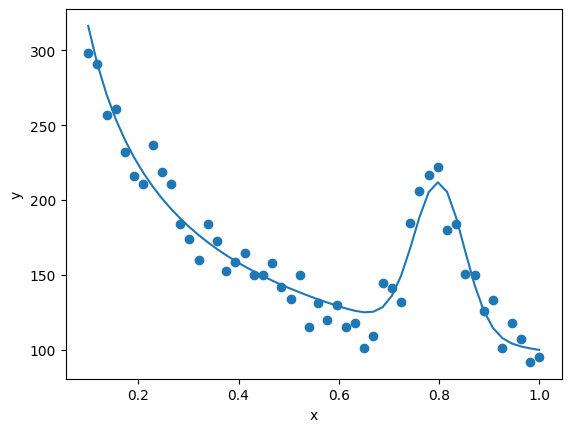

In [92]:
def bump_forward_model(x, amp_s, mu_s, std_s, amp_b, exp_b):

    y_b = amp_b * (x ** exp_b)  
    y_s = amp_s * np.exp(-((x - mu_s) ** 2) / (2 * std_s ** 2))

    y = y_b + y_s

    return y

x = np.linspace(0.1, 1, 50)
y_mu = bump_forward_model(x, 
                    amp_s=100, mu_s=0.8, std_s=0.05,  # Signal params
                    amp_b=100, exp_b=-0.5)  # Background params

y = np.random.poisson(y_mu)

plt.plot(x, y_mu)
plt.scatter(x, y)

plt.xlabel("x")
plt.ylabel("y")

## The explicit likelihood

In [93]:
from scipy.stats import poisson

def log_like(params, x, y):
    amp_s, mu_s, std_s, amp_b, exp_b = params
    mu = bump_forward_model(x, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(y, mu).sum()

log_like([100, 0.8, 0.05, 100, -0.5], x, y)

-197.49878529082673

In [94]:
def log_like_sig(params, x, y):
    amp_s, mu_s = params
    std_s, amp_b, exp_b = 0.05, 100, -0.5
    mu = bump_forward_model(x, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(y, mu).sum()

In [95]:
from scipy.optimize import minimize

opt = minimize(lambda params: -log_like_sig(params, x, y), x0=[1, 1])
opt.x

array([101.84583204,   0.79524424])

In [96]:
import emcee

def log_prior(params):
    amp_s, mu_s = params
    if 0 < amp_s < 200 and 0 < mu_s < 1:
        return 0
    else:
        return -np.inf
    
def log_post(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig(params, x, y)
    
ndim, nwalkers = 2, 100
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x, y))

pos = opt.x + 1e-4 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:15<00:00, 318.58it/s]


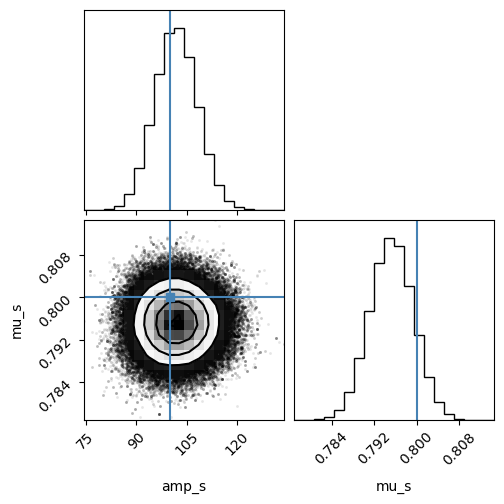

In [97]:
import corner

flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[100, 0.8]);

## The implicit likelihood

In [98]:
def bump_simulator(params, x):
    amp_s, mu_s = params
    std_s, amp_b, exp_b = 0.05, 100, -0.5
    y_mu = bump_forward_model(x, amp_s, mu_s, std_s, amp_b, exp_b)
    y = np.random.poisson(y_mu)
    return y

bump_simulator([100, 0.8], x)

array([330, 257, 283, 249, 233, 217, 232, 215, 197, 216, 207, 169, 190,
       169, 181, 169, 172, 152, 137, 149, 149, 157, 119, 153, 160, 128,
       111, 128, 123, 122, 123, 138, 112, 134, 139, 177, 194, 188, 218,
       220, 188, 157, 162, 133, 137, 110,  81,  86, 108,  89])

In [99]:
y_fwd = bump_simulator([100, 0.8], x)
crit = np.sum(np.abs(y - y_fwd) ** 2) / len(y)
crit

311.36

## Approximate Bayesian Computation (ABC)

In [100]:
from tqdm import tqdm

In [107]:
def abc(x, y, crit_thresh=500, n_samples=1000):
    samples = []
    total_attempts = 0
    progress_bar = tqdm(total=n_samples, desc="Accepted Samples", unit="samples")

    while len(samples) < n_samples:
        params = np.random.uniform(low=[0, 0], high=[200, 1])
        y_fwd = bump_simulator(params, x)  # Assuming bump_simulator is the function that generates bump signals
        crit = np.sum(np.abs(y - y_fwd) ** 2) / len(y)
        total_attempts += 1
        if crit < crit_thresh:
            samples.append(params)
            progress_bar.update(1)
            acceptance_ratio = len(samples) / total_attempts
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    return np.array(samples)

n_samples = 10_000
post_samples = abc(x, y, crit_thresh=400, n_samples=n_samples)

Accepted Samples: 100%|██████████| 10000/10000 [00:32<00:00, 304.94samples/s, acceptance_ratio=0.011]


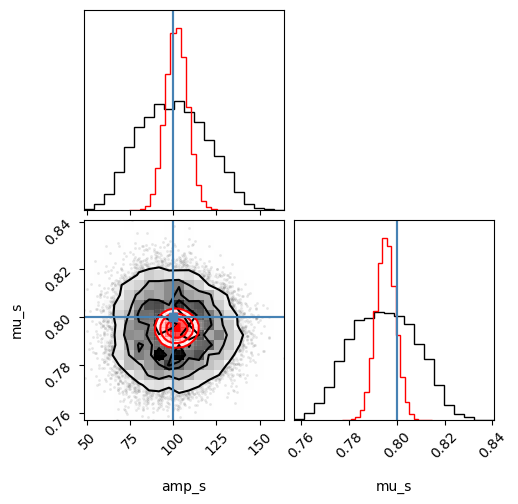

In [108]:
fig = corner.corner(post_samples, labels=["amp_s", "mu_s"], truths=[100, 0.8]);
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[100, 0.8], fig=fig, color="red", weights=np.ones(len(flat_samples)) * n_samples / len(flat_samples));

## Neural likelihood-ratio estimation (NRE)

In [109]:
n_train = 50_000

theta_samples = np.random.uniform(low=[0, 0], high=[200, 1], size=(n_train, 2))
y_samples = np.array([bump_simulator(theta, x) for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
y_samples = torch.tensor(y_samples, dtype=torch.float32)

# Normalize the data
y_mean = y_samples.mean(dim=0)
y_std = y_samples.std(dim=0)
y_samples = (y_samples - y_mean) / y_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create a MLP from the configurations"""
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

100%|██████████| 50000/50000 [00:00<00:00, 66167.15it/s]


In [110]:
import pytorch_lightning as pl

class NeuralRatioEstimator(pl.LightningModule):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.featurizer = build_mlp(input_dim=x_dim + y_dim, hidden_dim=128, output_dim=1, layers=4)

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, y):

        # Repeat x in groups of 2 along batch axis
        x = x.repeat_interleave(2, dim=0)

        # Get a shuffled version of y
        y_shuffled = y[torch.randperm(y.shape[0])]

        # Interleave y and shuffled y
        y = torch.stack([y, y_shuffled], dim=1).reshape(-1, y.shape[1])

        # Get labels; ones for pairs from joint, zeros for pairs from marginals
        labels = torch.ones(x.shape[0], device=x.device) 
        labels[1::2] = 0.0

        # Pass through parameterized classifier to get logits
        logits = self(torch.cat([x, y], dim=1))
        probs = torch.sigmoid(logits).squeeze()

        return nn.BCELoss(reduction='none')(probs, labels)


    def training_step(self, batch, batch_idx):
        theta, y = batch
        loss = self.loss(theta, y).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        theta, y = batch
        loss = self.loss(theta, y).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [112]:
nre = NeuralRatioEstimator(x_dim=50, y_dim=2)
nre.loss(y_samples[:64], theta_samples[:64])

tensor([0.6661, 0.7211, 0.6657, 0.7213, 0.6657, 0.7213, 0.6667, 0.7201, 0.6658,
        0.7213, 0.6664, 0.7207, 0.6659, 0.7211, 0.6658, 0.7212, 0.6663, 0.7208,
        0.6658, 0.7212, 0.6661, 0.7209, 0.6658, 0.7213, 0.6672, 0.7198, 0.6674,
        0.7195, 0.6659, 0.7214, 0.6655, 0.7215, 0.6662, 0.7210, 0.6659, 0.7213,
        0.6656, 0.7215, 0.6658, 0.7212, 0.6666, 0.7205, 0.6662, 0.7209, 0.6657,
        0.7212, 0.6658, 0.7212, 0.6663, 0.7209, 0.6660, 0.7211, 0.6658, 0.7213,
        0.6668, 0.7203, 0.6666, 0.7204, 0.6659, 0.7212, 0.6657, 0.7215, 0.6671,
        0.7199, 0.6659, 0.7212, 0.6655, 0.7214, 0.6657, 0.7213, 0.6660, 0.7210,
        0.6645, 0.7226, 0.6659, 0.7213, 0.6646, 0.7224, 0.6657, 0.7213, 0.6655,
        0.7215, 0.6660, 0.7210, 0.6666, 0.7204, 0.6670, 0.7203, 0.6675, 0.7194,
        0.6657, 0.7213, 0.6657, 0.7215, 0.6658, 0.7213, 0.6678, 0.7192, 0.6652,
        0.7219, 0.6658, 0.7214, 0.6653, 0.7217, 0.6657, 0.7214, 0.6658, 0.7212,
        0.6662, 0.7208, 0.6656, 0.7214, 

In [113]:
from torch.utils.data import TensorDataset, DataLoader, random_split

val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(y_samples))

dataset = TensorDataset(y_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(y_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


In [114]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=nre, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type       | Params
------------------------------------------
0 | featurizer | Sequential | 73.0 K
------------------------------------------
73.0 K    Trainable params
0         Non-trainable params
73.0 K    Total params
0.292     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [115]:
def log_like(params, x):
        
    x = torch.Tensor(x)
    params = torch.Tensor(params)

    # Normalize
    x = (x - y_mean) / y_std
    params = (params - theta_mean) / theta_std

    x = torch.atleast_1d(x)
    params = torch.atleast_1d(params)
    return nre.featurizer(torch.cat([x, params], dim=-1)).squeeze()

params_test = np.array([90, 0.8])
y_test = bump_simulator(params_test, x)

log_like(params_test, y_test)

tensor(5.1817, grad_fn=<SqueezeBackward0>)

In [116]:
def log_post(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(params, x)

In [117]:
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(y_test,))

pos = opt.x + 1e-4 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:25<00:00, 199.41it/s]


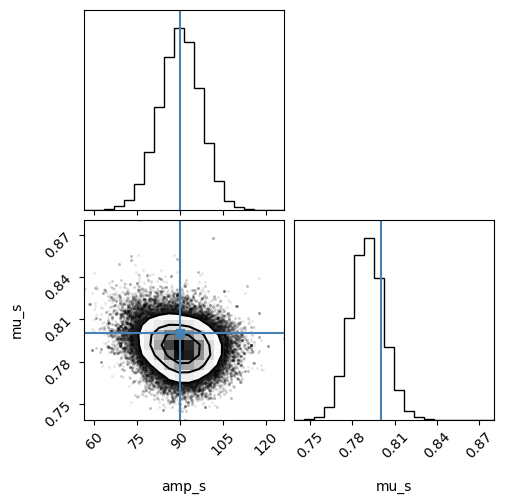

In [118]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

## Neural posterior estimation (NPE)

In [144]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation


In [148]:
def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

flow = get_flow()

samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=torch.randn(2, 16))
print(samples.shape, log_prob.shape)

torch.Size([2, 100, 2]) torch.Size([2, 100])


In [335]:
class NeuralPosteriorEstimator(pl.LightningModule):
    def __init__(self, featurizer, d_context=16):
        super().__init__()
        self.featurizer = featurizer
        self.flow = get_flow(d_in=2, d_hidden=32, d_context=d_context, n_layers=4)

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):
        context = self(x)
        return -self.flow.log_prob(inputs=theta, context=context)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [173]:
npe = NeuralPosteriorEstimator(featurizer=build_mlp(input_dim=50, hidden_dim=128, output_dim=16, layers=4))
npe.loss(y_samples[:64], theta_samples[:64])

tensor([5.1357, 5.1804, 5.2756, 5.1445, 5.2140, 5.1719, 5.2550, 5.2833, 5.4298,
        5.2476, 5.3189, 5.3322, 5.1469, 5.1853, 5.3031, 5.2340, 5.1437, 5.3451,
        5.2826, 5.1599, 5.1742, 5.1429, 5.2551, 5.4265, 5.2800, 5.5566, 5.2944,
        5.1343, 5.2816, 5.7471, 5.1805, 5.2714, 5.1753, 5.1629, 5.2694, 5.2216,
        5.1311, 5.2857, 5.1806, 5.2444, 5.2387, 5.2780, 5.2814, 5.1467, 5.1434,
        5.2227, 5.2717, 5.2806, 5.1479, 5.1290, 5.1907, 5.1479, 5.2095, 5.1948,
        5.1230, 5.2049, 5.2264, 5.1876, 5.2130, 5.3182, 5.2677, 5.3694, 5.2079,
        5.2908], grad_fn=<NegBackward0>)

In [174]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | featurizer | Sequential | 74.6 K
1 | flow       | Flow       | 24.3 K
------------------------------------------
99.0 K    Trainable params
0         Non-trainable params
99.0 K    Total params
0.396     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
params_test = np.array([90, 0.8])
y_test = bump_simulator(params_test, x)

In [181]:
y_test_norm = (torch.Tensor(y_test) - y_mean) / y_std
context = npe.featurizer(y_test_norm).unsqueeze(0)

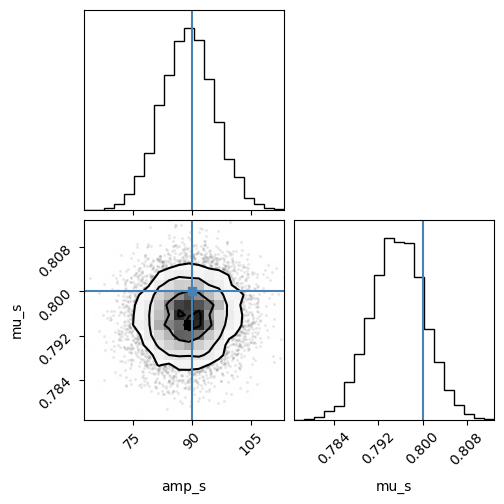

In [186]:
samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()
corner.corner(samples_test, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

## A more complicated example: distribution of point sources in a 2D image

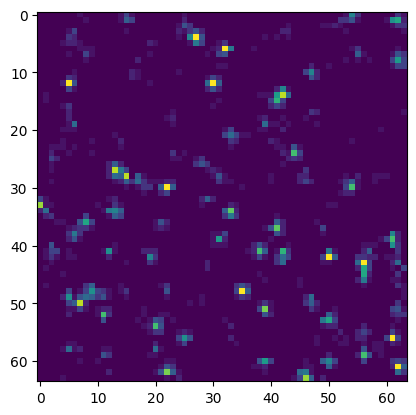

In [768]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
from astropy.convolution import convolve, Gaussian2DKernel

def _draw_m_sub(n_sub, m_sub_min, m_sub_max, beta):
    """
    Draw subhalo masses from SHMF with slope `beta` and min/max masses `m_sub_min` and `m_sub_max` . Stolen from:
    https://stackoverflow.com/questions/31114330/python-generating-random-numbers-from-a-power-law-distribution
    """
    u = np.random.uniform(0, 1, size=n_sub)
    m_low_u, m_high_u = m_sub_min ** (beta + 1), m_sub_max ** (beta + 1)
    return (m_low_u + (m_high_u - m_low_u) * u) ** (1.0 / (beta + 1.0))


def simulate_sources(amp_b, exp_b, s_min=0.5, s_max=50.0, box_size=1., resolution=64, sigma_psf=0.01):
    """ Simulate a map of point sources with mean counts drawn from a power law (Pareto) distribution dn/ds = amp_b * s ** (exp_b - 1)
    """
    # Get number of sources by analytically integrating dn/ds and taking Poisson realization
    n_sources = np.random.poisson(-amp_b * (s_min ** (exp_b - 1)) / (exp_b - 1))

    # Draw fluxes from truncated power law amp_b * s ** (exp_b - 1), with s_min and s_max as the bounds
    fluxes = _draw_m_sub(n_sources, s_min, s_max, exp_b)

    positions = np.random.uniform(0., box_size, size=(n_sources, 2))
    bins = np.linspace(0, box_size, resolution + 1)

    pixel_size = box_size / resolution
    kernel = Gaussian2DKernel(x_stddev=1.0 * sigma_psf / pixel_size)

    mu_signal = binned_statistic_2d(x=positions[:, 0], y=positions[:, 1], values=fluxes, statistic='sum', bins=bins).statistic
    counts = np.random.poisson(convolve(mu_signal, kernel))
                
    return fluxes, counts

fluxes, counts = simulate_sources(amp_b=100., exp_b=-1.2)
plt.imshow(counts, cmap='viridis', vmax=20)


### Explicit likelihood

Intractable!

### Neural posterior estimation

In [772]:
n_train = 10_000

# Sample from prior, then simulate
theta_samples = np.random.uniform(low=[10., -3.], high=[200., -0.99], size=(n_train, 2))
x_samples = np.array([simulate_sources(theta[0], theta[1])[1] for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.Tensor(theta_samples)
x_samples = torch.Tensor(x_samples)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std


100%|██████████| 10000/10000 [00:07<00:00, 1380.35it/s]


In [773]:
val_fraction = 0.1
batch_size = 64
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


In [774]:
class CNN(nn.Module):
    def __init__(self, output_dim):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        
        x = x.unsqueeze(1)
        
        x = self.pool1(F.leaky_relu(self.conv1(x), negative_slope=0.02))
        x = self.pool2(F.leaky_relu(self.conv2(x), negative_slope=0.02))

        x = x.view(x.size(0), -1)

        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)

        return x


In [775]:
npe = NeuralPosteriorEstimator(featurizer=CNN(output_dim=32), d_context=32)
npe.loss(x_samples[:64], theta_samples[:64])

tensor([4.7807, 5.0661, 5.6064, 4.8414, 5.2721, 5.1782, 5.1394, 4.5396, 5.2940,
        4.9832, 5.3210, 4.8233, 4.9077, 5.2524, 4.6498, 5.3039, 4.8728, 4.9092,
        4.6247, 5.2504, 5.0651, 4.5776, 4.9578, 5.2259, 4.9733, 4.9010, 5.7613,
        4.9311, 5.8010, 4.7994, 5.2386, 5.0238, 4.8817, 5.2986, 5.1715, 5.8087,
        4.3067, 5.0713, 5.6755, 5.5487, 5.8773, 5.8360, 5.0341, 4.9527, 4.9756,
        5.2860, 4.8766, 5.4434, 5.3742, 4.4698, 4.7642, 4.8594, 5.8078, 5.1742,
        4.9707, 4.9733, 5.1908, 5.4139, 4.5615, 4.3635, 4.8296, 5.8348, 4.4559,
        4.8666], grad_fn=<NegBackward0>)

In [776]:
trainer = pl.Trainer(max_epochs=15)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type | Params
------------------------------------
0 | featurizer | CNN  | 265 K 
1 | flow       | Flow | 30.5 K
------------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.184     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [777]:
npe = npe.eval()

In [784]:
params_test = np.array([15., -1.4])
x_test = simulate_sources(params_test[0], params_test[1])[1]

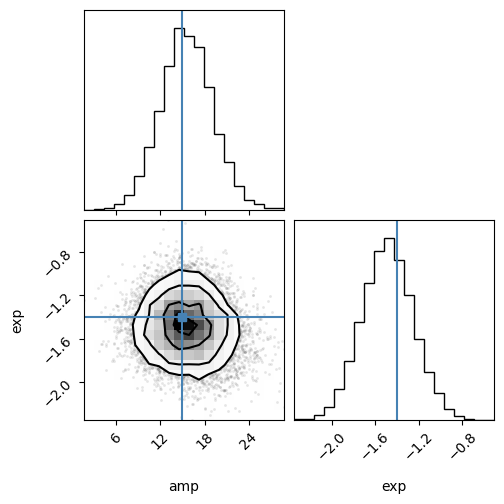

In [785]:
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm.unsqueeze(0))

samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

corner.corner(samples_test, labels=["amp", "exp"], truths=params_test);

## Statistical coverage

In [789]:
n_test = 200

x_test = torch.Tensor([simulate_sources(params_test[0], params_test[1])[1] for _ in range(n_test)])
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std

context = npe.featurizer(x_test_norm)

samples_test = npe.flow.sample(num_samples=1000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

In [790]:
def hpd(samples, credible_mass=0.95):
    """Compute highest posterior density (HPD) of array for given credible mass."""
    sorted_samples = np.sort(samples)
    interval_idx_inc = int(np.floor(credible_mass * sorted_samples.shape[0]))
    n_intervals = sorted_samples.shape[0] - interval_idx_inc
    interval_width = np.zeros(n_intervals)
    for i in range(n_intervals):
        interval_width[i] = sorted_samples[i + interval_idx_inc] - sorted_samples[i]
    hdi_min = sorted_samples[np.argmin(interval_width)]
    hdi_max = sorted_samples[np.argmin(interval_width) + interval_idx_inc]
    return hdi_min, hdi_max

hpd(samples_test[0, :, 0], credible_mass=0.2)

(14.78524, 16.895554)

In [791]:
i_param = 1
p_nominals = np.linspace(0.01, 0.99, 20)
contains_true = np.zeros((n_test, len(p_nominals)))

for i, sample in enumerate(samples_test[:, :, i_param]):
    for j, p_nominal in enumerate(p_nominals):
        hdi_min, hdi_max = hpd(sample, credible_mass=p_nominal)
        if hdi_min < params_test[i_param] < hdi_max:
            contains_true[i, j] = 1

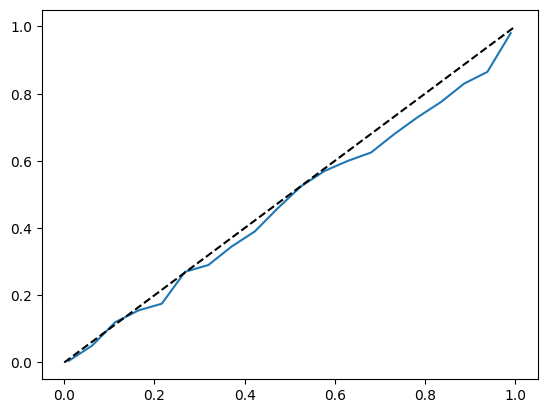

In [792]:
plt.plot(p_nominals, contains_true.sum(0) / n_test)
plt.plot([0, 1], [0, 1], color="black", linestyle="--")